In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Introduction to QAMpy - Pilot DSP Module

Here we demonstrate our pilot-based DSP using QPSK pilots. It's integrated in the QAMpy package and processing can be done using either blind methods or pilot-based

It is build based on the following principle:    
Signal is divided into frames of a given length.
Each frame starts with a pilot-sequnence followed by the payload
Additional pilots are inserted into the payload for continous tracking
    
Frame strutured in the following way:
    
    Pilot Sequence: N pilot symbols long. 
        Used for: 
            Frame syncronization (alignment)
            Equalization and polarization de-multiplexing
            Frequency offset estimation
            
    Phase Pilots: Periodically inserted at a ratio of P (Ex. P=32 corresponds to 1 pilot and 31 payload symbols)
        Used for:
            Phase tracking
            
    Payload: Data kept in the pilot frame
        Our pilot-dsp uses no information from the data for processing and is  fully modulation format independent. 
                    

In [2]:
from qampy import impairments, helpers, signals, equalisation,phaserec,core

## Demonstration using PM-64QAM Payload data
The signal object class contains functionality to generate a frame including both pilot symbols and payload. The pilot frame is just like any other object from the signal class and the same structure applies. 


Syntax:

    SignalWithPilots(M, frame_len, pilot_seq_len, pilot_ins_rat, nframes=1, pilot_scale=1, Mpilots=4,
                dataclass=SignalQAMGrayCoded, nmodes=1, dtype=np.complex128,  **kwargs)
    





In [3]:
mysig = signals.SignalWithPilots(64,2**16,2**10,32,nmodes=2,Mpilots=4,nframes=1,fb=24e9)

Text(0.5, 1.0, 'Pilots')

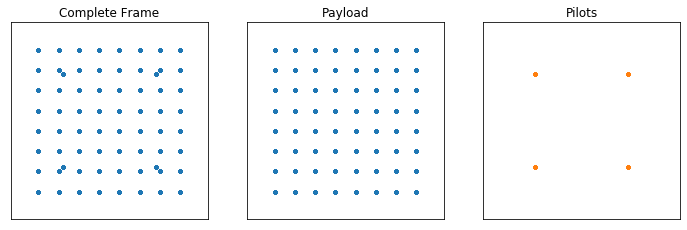

In [4]:
figure(figsize=(12,6))
subplot(131)
plot(mysig[0].real.flatten(),mysig[0].imag.flatten(),'.')
axis("square")
xticks([])
yticks([])
axis([-1.5,1.5,-1.5,1.5])
title("Complete Frame")

subplot(132)
plot(mysig.get_data()[0].real.flatten(),mysig.get_data()[0].imag.flatten(),'.')
axis("square")
xticks([])
yticks([])
axis([-1.5,1.5,-1.5,1.5])
title("Payload")

subplot(133)
plot(mysig.extract_pilots()[0].real.flatten(),mysig.extract_pilots()[0].imag.flatten(),'.',color="C1")
axis("square")
xticks([])
yticks([])
axis([-1.5,1.5,-1.5,1.5])
title("Pilots")

## Let's try the signal. Generate a new object with multiple frames

In [5]:
mysig = signals.SignalWithPilots(64,2**16,2**10,32,nmodes=2,Mpilots=4,nframes=2,fb=24e9)

### Add transmitter-side pulse-shaping

Text(0.5, 1.0, 'Channel after pulse-shaping')

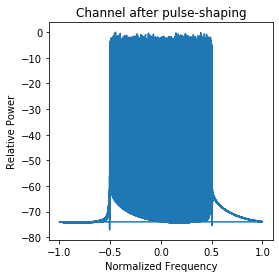

In [6]:
mysig2 = mysig.resample(mysig.fb*2,beta=0.01)

figure(figsize=(4,4))
faxis=fftfreq(mysig2.shape[1],1/2)
psd = 20*log10(abs(fft.fft(mysig2[0])))
plot(faxis,psd-psd.max())
xlabel("Normalized Frequency")
ylabel("Relative Power")
title("Channel after pulse-shaping")

### Simulate the channel

Impairments containe a suitable function: simulate_transmission

    Input:
        signal object: Signal to be modified
        snr: Output signal to noise ratio (SNR), AWGN
        dgd: Amount of dgd to be added [s]
        freq_off: Frequency offset
        lwdth: Laser linewidth (combined Tx and Rx)
        roll_frame_sync: Rolls the frame to enable synchronization. Requires >1 frame for accurate processing.


In [7]:
mysig3 = impairments.simulate_transmission(mysig2,snr=20,dgd=10e-12, freq_off=50e6,lwdth=100e3,roll_frame_sync=True)

## Receiver side DSP


### Synchronization

In [8]:
mysig3.sync2frame()

TypeError: Invalid call to pythranized function `apply_filter_to_signal(complex128[:, :] (reshaped), int, complex128[:, :, :] (reshaped))'
Candidates are:

    - apply_filter_to_signal(complex64[:,:], int, complex64[:,:,:])
    - apply_filter_to_signal(complex128[:,:], int, complex128[:,:,:])


### Correct coarse frequency offset found by the syncronization algorithm

In [9]:
print("FOE" + str(["%.4f"%i for i in mysig3._foe]))
mysig3.corr_foe()

FOE['0.0021', '0.0021']


### Run the pilot-based Equalizer

In [10]:
eq_sig = equalisation.pilot_equalizer(mysig3,(1e-3,1e-3),45,foe_comp=False,methods=("cma","sbd"))

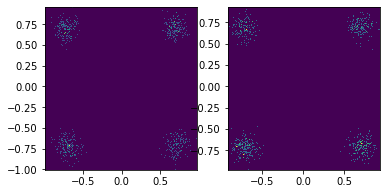

In [11]:
figure(figsize=(6,3))
subplot(121)
a = hist2d(eq_sig[1][0][:1024].real,eq_sig[1][0][:1024].imag,bins=200)

subplot(122)
a = hist2d(eq_sig[1][1][:1024].real,eq_sig[1][1][:1024].imag,bins=200)

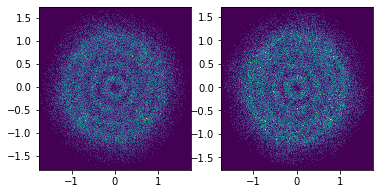

In [12]:
figure(figsize=(6,3))
subplot(121)
a = hist2d(eq_sig[1][0].flatten().real,eq_sig[1][0].flatten().imag,bins=200)

subplot(122)
a = hist2d(eq_sig[1][1].flatten().real,eq_sig[1][1].flatten().imag,bins=200)

### Pilot-based Carrier Phase Recovery (CPE)

In [13]:
cpe_sig = phaserec.pilot_cpe(eq_sig[1],N=5,use_seq=False)

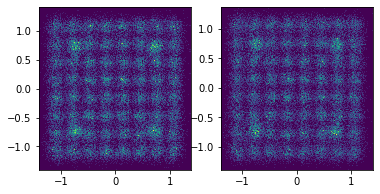

In [14]:
figure(figsize=(6,3))
subplot(121)
a = hist2d(cpe_sig[0][0].flatten().real,cpe_sig[0][0].flatten().imag,bins=200)

subplot(122)
a = hist2d(cpe_sig[0][1].flatten().real,cpe_sig[0][1].flatten().imag,bins=200)

### Calculate standard performance metrics

In [15]:
ber = cpe_sig[0].cal_ber()
ser = cpe_sig[0].cal_ser()
gmi = cpe_sig[0].cal_gmi()[0]
snr = cpe_sig[0].est_snr()
snr_pilots = cpe_sig[0].est_snr(use_pilots=True)
print("Performance metrics")
print("BER Avg: %.2e, X-pol: %.2e Y-pol: %.2e"%(ber.mean(),ber[0],ber[1]))
print("SER Avg: %.2e, X-pol: %.2e Y-pol: %.2e"%(ser.mean(),ser[0],ser[1]))
print("GMI Avg: %.2f, X-pol: %.2f Y-pol: %.2f"%(gmi.mean(),gmi[0],gmi[1]))

Performance metrics
BER Avg: 2.41e-02, X-pol: 2.43e-02 Y-pol: 2.40e-02
SER Avg: 1.40e-01, X-pol: 1.41e-01 Y-pol: 1.39e-01
GMI Avg: 5.46, X-pol: 5.46 Y-pol: 5.46


### Propper extraction of data and visualization of resulting constellation diagrams

In [ ]:
tmp = cpe_sig[0].get_data()
figure(figsize=(6,3))
subplot(121)
a = hist2d(tmp[0].flatten().real,tmp[0].flatten().imag,bins=200)

subplot(122)
a = hist2d(tmp[1].flatten().real,tmp[1].flatten().imag,bins=200)